In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import interpolate
import astropy.units as u
import os
path='/Users/s2537809/Documents/DESI-STACKING'#specify code directory
os.chdir(path)
import stack_code as sc
import importlib
import fnmatch
import extinction as ext
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy.modeling import models
from astropy.table import Table
from matplotlib import gridspec
import spectres
import time
import warnings

#pip install lmfit, extinction, sfdmap, spectres

import pandas as pd



In [2]:
def get_mag_i(wave_spec,flux_spec,sigma_spec):
    filter_data = np.genfromtxt(path+'/SDSS filter curves.txt',delimiter='',dtype='str',unpack=True,skip_header=4) #can potentially leave SDSS filter curve in
    idx_i = np.where(filter_data[4]!='...')[0]
    i_filter = np.array([float(filter_data[4][idx_i][i]) for i in range(len(filter_data[4][idx_i]))])#sensitivity through 1.3 airmasses for a point source
    i_wave = np.array([float(filter_data[0][idx_i][i]) for i in range(len(filter_data[0][idx_i]))])
    t_i = interpolate.interp1d(i_wave,i_filter)
    idx_i = np.where((wave_spec>=i_wave[0])&(wave_spec<=i_wave[-1])&(sigma_spec!=np.inf))[0]
    if idx_i.size!=0:
        F_i = sum(flux_spec[idx_i]*t_i(wave_spec[idx_i]))/sum(t_i(wave_spec[idx_i]))
        F_i_Jy = F_i*10**-17*(3.34*10**4.0*7480.0**2.0)#convert to out units -> 10^-17 erg cm^-2 s^-1 A^-1 
        mag_i = -2.5*np.log10(F_i_Jy) + 8.9
        return mag_i
    else:
        print(1)
        return np.nan
    
# Ignore warnings due to spec_var=0
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")

def get_spectra(spec_path):
    spec_list = os.listdir(spec_path)
    print('Number of spectra =', len(spec_list))
    num = 0
    sourceID = []
    flux_spec, sigma_spec, wave_spec = [], [], []
    RA, DEC, z = [],[],[] 

    start = time.time()
    for i in range(len(spec_list)):

            spec=fits.open(spec_path+spec_list[i],memmap=False)  
            RA.append(spec[2].data['PLUG_RA'][0])
            DEC.append(spec[2].data['PLUG_DEC'][0])
            z.append(spec[2].data['z'][0])
                        
            bad_pix = np.where(spec[1].data['ivar']==0)
            flux = spec[1].data['flux']
            flux[bad_pix] = np.nan
            flux_spec.append(flux)
            sigma_spec.append(np.sqrt(1/spec[1].data['ivar']))
            wave_vac = 10**spec[1].data['loglam']
            wave_spec.append(wave_vac)
            print(spec[1].data['ivar'])
                            
            num = num+1
            sourceID.append([spec[2].data['PLATE'][0], spec[2].data['MJD'][0], spec[2].data['FIBERID'][0]])
   
            spec.close()
            del spec
            
    end = time.time()
    print((end-start)/60,'min')
    

    wave_spec = np.array(wave_spec,dtype=object)
    flux_spec = np.array(flux_spec,dtype=object)
    sigma_spec = np.array(sigma_spec,dtype=object)
    z = np.array(z)
    RA = np.array(RA)
    DEC = np.array(DEC)
    sourceID = np.array(sourceID,dtype=object)
    id_spec = [sourceID[:,0],sourceID[:,1],sourceID[:,2]]
    
    m_i = np.full(len(z),np.nan) 
    for i in range(len(z)):
        wave_max = max(wave_spec[i])
        m_i[i] = get_mag_i(wave_spec[i],flux_spec[i], sigma_spec[i])#some are below 7000A, other have ivar=0 in the vicinity of the i filter

    return wave_spec, flux_spec, sigma_spec, z, RA, DEC, id_spec, m_i   




def get_stack(spec, zbins=None):# can add redshift ranges i.e zbins = [[0.0,0.1],[0.1,0.2]]
    wave_spec, flux_spec, sigma_spec, z, RA, DEC, id_spec, mi = spec
    stack, sim_stack, corr_stack, ids = sc.stack_spectra(wave_spec,flux_spec,sigma_spec,
                               z, RA, DEC, zbins = zbins)
    return stack, sim_stack, corr_stack, ids

In [3]:
SFG_spec=get_spectra(path+'/SFG_sample/')# extract the file 
## this file contains 100 fits files which are spectra


#print(path+'/SFG_sample/')
#print (pd.DataFrame(SFG_spec))
#print(np.shape(SFG_spec[1]))
#print(SFG_spec[1])

Number of spectra = 100
[0.21949305 0.24220395 0.23909627 ... 0.38849467 0.4008977  0.3835977 ]
[0.10174409 0.09640878 0.10064267 ... 0.772772   0.70472586 0.6748907 ]
[0.20052066 0.20871887 0.20673406 ... 0.5130995  0.5065274  0.4861112 ]
[0.0441475  0.12714282 0.12669726 ... 1.0148395  0.9849273  0.938662  ]
[0.11050455 0.         0.11568762 ... 0.76845586 0.8188544  0.7970481 ]
[0.25450838 0.23801932 0.23500735 ... 0.60153836 0.5569197  0.54501873]


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_66069/2858545959.py:40: RuntimeWarning: divide by zero encountered in divide
  sigma_spec.append(np.sqrt(1/spec[1].data['ivar']))


[0.10933034 0.11127058 0.11291465 ... 0.95839655 0.94974464 0.88686657]
[0.11983968 0.1467961  0.14729147 ... 1.1708205  1.1134549  1.1180806 ]
[0.22502252 0.2339833  0.24674034 ... 0.57749104 0.5480334  0.51320827]
[0.10397828 0.10231354 0.10132445 ... 0.40728396 0.43978417 0.42025337]
[0.1745794  0.18556902 0.19332303 ... 0.89822346 0.34570602 0.30982828]
[0.14832464 0.14749274 0.1493035  ... 0.9623022  0.80972177 0.8010739 ]
[0.21788485 0.207442   0.21631604 ... 0.47477317 0.44792598 0.42389938]
[0.22218706 0.20550945 0.21096039 ... 0.58618987 0.5602115  0.52820915]
[0.14669076 0.13630451 0.12895644 ... 0.60326856 0.59352785 0.5743893 ]
[0.21833281 0.2166294  0.12900518 ... 0.6457386  0.61627656 0.5779476 ]
[0.19133505 0.19115296 0.20161474 ... 0.6191135  0.62250274 0.577202  ]
[0.16196398 0.16628462 0.18262602 ... 0.4022267  0.361594   0.34397158]
[0.09481682 0.         0.09286176 ... 0.9952548  0.912235   0.8751105 ]
[0.12655482 0.12606613 0.14063612 ... 0.75263345 0.78130174 0.69

In [4]:
print(SFG_spec[4][2])

114.61324


In [5]:

print(np.shape(SFG_spec[2]))
print(SFG_spec[3])
print(np.shape(SFG_spec[2][3]))

(100,)
[0.08667316 0.06198035 0.17558728 0.07079329 0.07241607 0.17853884
 0.16551073 0.09866627 0.09704714 0.06130618 0.05988472 0.14080888
 0.09690603 0.09432431 0.06844141 0.1965527  0.07320008 0.09387366
 0.11870744 0.09786797 0.04681971 0.0609969  0.08518089 0.13955624
 0.08464739 0.12362599 0.09752107 0.08015788 0.09529609 0.12136975
 0.07320638 0.05115099 0.08612226 0.07347495 0.11757212 0.13233802
 0.08572347 0.09531336 0.05694966 0.08010269 0.10094161 0.13134629
 0.17395413 0.09591377 0.06287095 0.06025798 0.07430857 0.08425606
 0.11664417 0.08666295 0.17184359 0.09456509 0.05267122 0.08702144
 0.07913958 0.08530298 0.08758557 0.08489409 0.09188673 0.09227233
 0.15708238 0.09683638 0.06241925 0.09006957 0.08974007 0.16854846
 0.09418803 0.09752595 0.13171525 0.0512048  0.08460294 0.0728116
 0.07705418 0.12416049 0.09743647 0.11722791 0.10072387 0.13472866
 0.09782445 0.12752983 0.20189102 0.0814108  0.07114657 0.04787721
 0.18003118 0.04740048 0.07092067 0.11685929 0.09633078 

In [6]:
#stack all available spectra

SFG_stack = get_stack(SFG_spec)

zbin: [(0.045071498, 0.20189102)]
Number of spectra to stack =  100
Spectra corrected for foreground extinction.
100
Fnorm: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Stack[0]: [2.08360135 1.99941469 1.73423772 ... 0.87764919 1.06204915 1.06204915]
Redshifted wave_spec min: 3525.3413
Redshifted wave_spec max: 8480.101
Redshifted wave_spec: [3525.3413 3526.1523 3526.9634 ... 8476.196  8478.15   8480.101 ]
Min wave_tem: 3162.5
Max wave_tem: 8814.5
wave_tem: [3162.5 3163.5 3164.5 ... 8812.5 8813.5 8814.5]
flux_new
[0.55276327 0.53659841 0.5462902  ... 0.91306859 0.90441553 0.90496974]
Redshifted wave_spec min: 3593.217
Redshifted wave_spec max: 8677.276
Redshifted wave_spec: [3593.217  3594.0457 3594.8726 ... 8673.281  8675.281  8677.276 ]
Min wave_tem: 3162.5
Max wave_tem: 8814.5
wave_tem: [3162.5 3163.5 3164.5 ... 8812.5 8813.5 8814.5]
flux

In [7]:
#stack spectra in two redshift bins (i.e 0<z<0.1 and 0.1<z<0.2)
SFG_stacks = get_stack(SFG_spec, zbins=[[0.0,0.1],[0.1,0.2]])

zbin: [[0.0, 0.1], [0.1, 0.2]]
Number of spectra to stack =  70
Spectra corrected for foreground extinction.
70
Fnorm: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Stack[0]: [0.78239577 0.54401596 0.6671722  ... 0.90016959 1.08930124 1.08930124]
Redshifted wave_spec min: 3525.3413
Redshifted wave_spec max: 8480.101
Redshifted wave_spec: [3525.3413 3526.1523 3526.9634 ... 8476.196  8478.15   8480.101 ]
Min wave_tem: 3457.5
Max wave_tem: 8814.5
wave_tem: [3457.5 3458.5 3459.5 ... 8812.5 8813.5 8814.5]
flux_new
[0.55510452 0.54973835 0.54395129 ... 0.95590232 0.95048099 0.94604253]
Redshifted wave_spec min: 3593.217
Redshifted wave_spec max: 8677.276
Redshifted wave_spec: [3593.217  3594.0457 3594.8726 ... 8673.281  8675.281  8677.276 ]
Min wave_tem: 3457.5
Max wave_tem: 8814.5
wave_tem: [3457.5 3458.5 3459.5 ... 8812.5 8813.5 8814.5]
flux_new


{'zbin=0': {'flux': array([2.13545724, 2.0635632 , 1.79085433, ..., 0.90736568, 1.09452177,
       1.09338156]), 'flux_err': array([2.3712171 , 2.24931184, 1.92862971, ..., 0.98968331, 1.20310428,
       1.20865208]), 'N': array([1., 1., 1., ..., 1., 1., 1.]), 'wln': array([3162.5, 3163.5, 3164.5, ..., 8812.5, 8813.5, 8814.5]), 'norm_range': array([3930, 3931, 3932, 3933, 3934, 3935, 3936, 3937, 3938, 3939, 3940,
       3941, 3942, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951,
       3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962,
       3963, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973,
       3974, 3975, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984,
       3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995,
       3996, 3997, 3998, 3999, 4000, 4001, 4002, 4003, 4004, 4005, 4006,
       4007, 4008, 4009, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017,
       4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028,

Text(0.5, 0, 'Rest-frame wavelength')

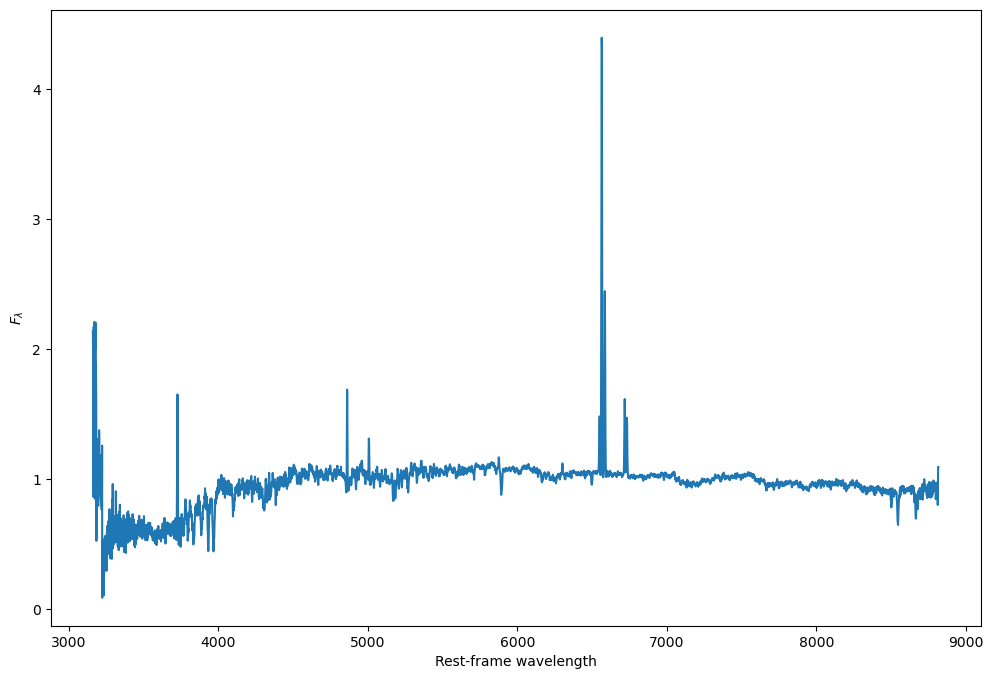

In [8]:
plt.figure(figsize=(12,8))
plt.plot(SFG_stack[2]['zbin=0']['wln'],SFG_stack[2]['zbin=0']['flux'])
plt.ylabel('$F_{\lambda}$')
plt.xlabel('Rest-frame wavelength')

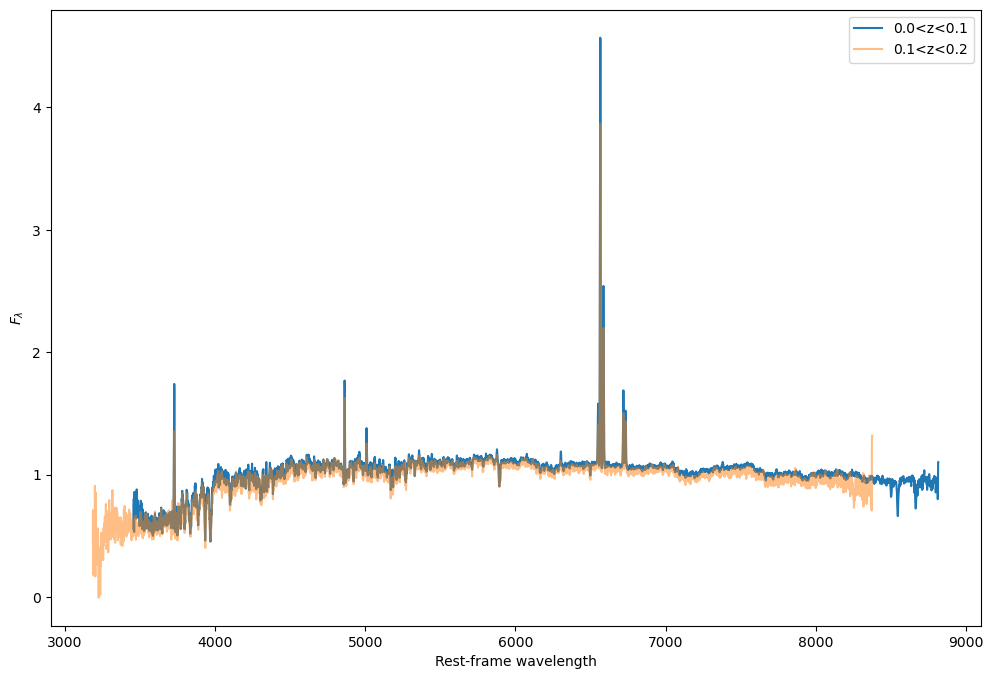

In [9]:
plt.figure(figsize=(12,8))
plt.plot(SFG_stacks[2]['zbin=0']['wln'],SFG_stacks[2]['zbin=0']['flux'], label='0.0<z<0.1')
plt.plot(SFG_stacks[2]['zbin=1']['wln'],SFG_stacks[2]['zbin=1']['flux'], label='0.1<z<0.2', alpha=0.5)
plt.ylabel('$F_{\lambda}$')
plt.xlabel('Rest-frame wavelength')
plt.legend()